<a id="installation"></a>
# Installation

In [3]:
!pip install -r scripts/requirements.txt


# Modules
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from lets_plot import *
from palmerpenguins import load_penguins
from urllib import request
from io import BytesIO
from sklearn.cluster import KMeans

# Fonctions
from scripts import import_eec


/opt/python/lib/python3.13/site-packages/palmerpenguins/penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Import des données

### Données de l'EEC de 2018 à 2024

#### Données brutes

Je n'ai pas trouvé les données dans la base Melodi et l'Insee mais directement en ligne sur le site. J'ai essayé d'utiliser la fonction `pd.read_csv()` pour les télécharger directement depuis l'URL, mais les données sont souvent compressées au format .zip avec un autre fichier de documentation. J'ai rédigé une fonction `pd.read_csv_from_zip()` qui importe le plus gros fichier .csv contenu dans le dossier zippé au bout de l'URL. J'ai aussi ajouté fait une copie des données sur le cloud de mon compte SSPCloud et mis un lien "backup" qu'on peut indiquer à la fonction si le lien direct ne fonctionne pas (j'ai vu que c'était tout le temps fait comme ça dans le cours).

In [4]:
# Liens vers les fichiers CSV accessibles directement depuis le site de l'Insee.
url_2024 = "https://www.insee.fr/fr/statistiques/fichier/8632441/FD_csv_EEC_2024.zip"
url_2023 = "https://www.insee.fr/fr/statistiques/fichier/8241122/FD_csv_EEC23.zip"
url_2022 = "https://www.insee.fr/fr/statistiques/fichier/7657353/FD_csv_EEC22.zip"
url_2021 = "https://www.insee.fr/fr/statistiques/fichier/6654604/FD_csv_EEC21.zip"
url_2020 = "https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip"
url_2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip"
url_2018 = "https://www.insee.fr/fr/statistiques/fichier/4191029/fd_eec18_csv.zip"

# J'ai aussi enregistré les fichiers .csv non compressés dans un dossier de mon compte SSPCloud,
# normalement on devrait pouvoir y accéder sans problème à ces adresses s'il y a un problème avec les autres:
url_2024_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2024.csv"
url_2023_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC23.csv"
url_2022_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2022.csv"
url_2021_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2021.csv"
url_2020_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC20.csv"
url_2019_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_EEC_2019.csv"
url_2018_backup = "https://minio.lab.sspcloud.fr/phobeika/open_eec/FD_csv_EEC18.csv"

# Si besoin, les dictionnaires de variables des différentes enquêtes sont à ces adresses (les variables ne sont pas les mêmes d'une année sur l'autre…) :
# url_doc_2018 = "https://www.insee.fr/fr/statistiques/fichier/4191029/EEC2018_dictionnaire_2020.pdf"
# url_doc_2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/EEC2019_dictionnaire_2020.pdf"
# url_doc_2020 = "https://www.insee.fr/fr/statistiques/fichier/5393560/EEC2020_Dictionnaire_Fichier_Detail.pdf"
# url_doc_2021 = "https://www.insee.fr/fr/statistiques/fichier/6654604/EEC%202021%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail.pdf"
# url_doc_2022 = "https://www.insee.fr/fr/statistiques/fichier/7657353/EEC%202022%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail.pdf"
# url_doc_2023 = "https://www.insee.fr/fr/statistiques/fichier/8241122/EEC%202023%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail_2024_07_17.pdf"
# url_doc_2024 = "https://www.insee.fr/fr/statistiques/fichier/8632441/EEC%202024%20_%20Dictionnaire%20des%20codes%20_%20Fichier%20detail_2024.pdf"



In [5]:
# Import depuis le site de l'Insee :
eec24 = import_eec.read_csv_from_zip(url_2024, backup_url = url_2024_backup, sep = ";")
eec23 = import_eec.read_csv_from_zip(url_2023, backup_url = url_2023_backup, sep = ";")
eec22 = import_eec.read_csv_from_zip(url_2022, backup_url = url_2022_backup, sep = ";")
eec21 = import_eec.read_csv_from_zip(url_2021, backup_url = url_2021_backup, sep = ";")
eec20 = import_eec.read_csv_from_zip(url_2020, backup_url = url_2020_backup, sep = ";")
eec19 = import_eec.read_csv_from_zip(url_2019, backup_url = url_2019_backup, sep = ";")
eec18 = import_eec.read_csv_from_zip(url_2018, backup_url = url_2018_backup, sep = ";")

Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/8632441/FD_csv_EEC_2024.zip
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/8241122/FD_csv_EEC23.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_csv_EEC23.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/7657353/FD_csv_EEC22.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_EEC_2022.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/6654604/FD_csv_EEC21.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_EEC_2021.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip
Aucun mot-clé fourni : sélection du CSV le plus gros : FD_csv_EEC20.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip
Aucun mot-clé fourni : sélection du CSV le pl

In [6]:
# Variables qu'on voudrait garder (dictionnaire des codes 2018)
# - ACTEU : activité au sens du BIT (1: actifs occupés 2: chômeurs 3: inactifs)
# - AGE5 : je crois que c'est le plus détaillé au niveau de l'âge : il y a 5 classes d'âge - devient AGE6 en 2021
# - ANCENTR4 : ancienneté dans l'entreprise ou dans la fonction publique, 4 postes
# - ANNEE : année de référence de l'enquête
# - CATAU2010R : catégorie de la commune (pas sûr de comprendre les modalités)
# - CHPUB : nature de l'employeur principal
# - CSA : catégorie socioprofessionnelle pour les inactifs (2 chiffres)
# - CSE : catégorie socioprofessionnelle pour les actifs (2 chiffres)
# - CSP : catégorie socioprofessionnelle pour les actifs occupés (2 chiffres)
# - DIP11 : diplôme le plus élevé obtenu
# - DUHAB : type de temps de travail
# - EMPNBH : nombre d'heures effectuées dans l'emploi principal pendant la semaine de référence
# - EXTRIAN : pondération
# - FONCTC : fonction de la profession
# - HHC6 : nombre d'heures travaillées en moyenne dans l'emploi principal
# - JOURTR : nombre de jours travaillés en général par semaine
# - NAFANT : nature de l'activité de l'emploi antérieur (pour chômeurs et inactifs)
# - NAFG021UN : nature de l'activité de l'emploi principale (NAF2 à 21 postes)
# - NONDIC : raison de la non disponibilité pour travailler sous deux semaines
# - PASTRA : n'a pas travaillé la semaine de référence mais a un emploi rémunéré
# - PUB3FP : statut public ou privé de l'employeur principal
# - QPRC : position professionnelle dans l'emploi principal
# - RABS : raison de l'absence au travail la semaine de référence, pour les personnes qui ont un emploi rémunéré (2 : congé maladie ou accident du travail)
# - RAISNREC : raison principale de la non recherche d'emploi durant les quatre semaines s'achevant par la semaine de référence (4 : problèmes de santé)
# - RAISNSOU : raison pour laquelle l'individu ne souhaite pas travaille actuellement (3 : a des problèmes de santé)
# - RAISON : raison de la non-disponibilité pour travailler davantage (pour ceux qui souhaitent faire plus d'heures de travail) (4 : pour raisons de santé)
# - SEXE
# - SOUA : souhait d'avoir un emploi en remplacement de l'emploi actuel ou à venir
# - STAT2 : salarié (2) ou non salarié (1)
# - TPPRED : temps de travail dans l'emploi principal, redressé et imputé de la non-réponse partielle
# - TRAREF : exercice d'au moins une heure de travail durant la semaine de référence
# - TRIM : trimestre de référence de l'enquête (1 à 4)

vars = ['ACTEU', 
        'AGE5', 
        'ANCENTR4', 
        'ANNEE', 
        'CATAU2010R', 
        'CHPUB', 
        'CSA', 
        'CSE', 
        'CSP', 
        'DIP11', 
        'DUHAB', 
        'EMPNBH', 
        'EXTRIAN', 
        'FONCTC', 
        'HHC6', 
        'JOURTR', 
        'NAFANT', 
        'NAFG021UN',
        'NONDIC', 
        'PASTRA', 
        'PUB3FP', 
        'QPRC', 
        'RABS', 
        'RAISNREC', 
        'RAISNSOU', 
        'RAISON',
        'SEXE',
        'SOUA',
        'STAT2',
        'TPPRED',
        'TRAREF',
        'TRIM']

# Ça marche pour 2018, 2019 et 2020. Ensuite beaucoup de variables changent de nom (ou plus)

# Assemblage des tables des différentes années

Les variables présentes dans les différentes tables ne sont pas les mêmes d'année en année. Par exemple, la variable d'âge est en 5 modalités et s'appelle `AGE5` en 2018 et 2019 puis elle passe à 6 modalités avec un découpage différent à partir de 2020 et s'appelle alors `AGE6`. Dans un premier temps, on peut ne conserver que les variables qui sont présentes dans toutes les tables, en espérant que les modalités restent les mêmes la plupart du temps. Si on veut en utiliser d'autres, il faudra ajouter des recodages préalables.

In [7]:
# On crée une liste de tous tes DataFrames
dfs = [eec18, eec19, eec20, eec21, eec22, eec23, eec24]

# On calcule l'intersection des colonnes
vars_communes = set(dfs[0].columns)
for df in dfs[1:]:
    vars_communes = vars_communes.intersection(df.columns)

# On convertit en liste triée pour lecture
vars_communes = sorted(vars_communes)
print(f"{len(vars_communes)} variables communes :")
print(vars_communes)

33 variables communes :
['AAC', 'ACTEU', 'ANCCHOM', 'ANNEE', 'CHPUB', 'DISPPLC', 'ENFRED', 'EXTRIAN', 'HALOR', 'METRODOM', 'NAFANTG004N', 'NAFG004UN', 'NAFG010UN', 'NAFG017UN', 'NAFG021UN', 'NAFG038UN', 'NAFG088UN', 'OFFICC', 'PASTRA', 'PASTRB', 'PUB3FP', 'RABS', 'RAISTP', 'SEXE', 'SOUSEMPL', 'STATUT', 'STC', 'STPLC', 'TEMP', 'TPPRED', 'TRAREF', 'TRIM', 'TXTPPRED']


Il y a donc 33 variables qui sont présentes avec le même nom dans toutes les bases de 2018 à 2024. Pour ne pas s'encombrer avec des variables qu'on utilise pas, on peut faire une liste des variables qu'on veut utiliser parmi celles-ci, qu'on peut allonger selon les besoins.

In [8]:
# Liste des variables qu'on veut utiliser
core_vars = ['ACTEU', 'RABS', 'SEXE', 'RAISTP', 'TRIM', 'ANNEE', 'EXTRIAN']
# Concaténation des différents fichiers dans une seule tablea "eec_all"
eec_all = pd.concat(
    [eec18[core_vars], eec19[core_vars], eec20[core_vars], eec21[core_vars], eec22[core_vars], eec23[core_vars]],
    ignore_index = True)


In [9]:
# En fait on ne garde que les actifs en emploi (`ACTEU` == 1)
eec_actifs = eec_all[eec_all['ACTEU'] == 1]
eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)

/tmp/ipykernel_208402/116353697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)


In [10]:
LetsPlot.setup_html()

In [11]:
ggplot(eec_all, aes(x = 'SEXE')) + geom_bar()

## Le lien entre arrêts de travail et Covid-19

[Texte à retravailler - Brouillon]
Comment pallier l'absence de données sur les contaminations au Covid-19 en 2020 ? Pour déterminer les secteurs d'activité qui ont été les plus touchés, on peut utiliser les absences pour congé maladie comme proxy. En effet, cette variable est, logiquement, fortement corrélée au nombre d'hospitalisations liées au Covid-19.

### Récupération des données via l'API de Santé publique France

Tout d'abord, on peut récupérer les données concernant le nombre d'hospitalisations liées au Covid-19 via l'API Huwise de Santé publique France, sur le portail open data Odissé :  
https://odisse.santepubliquefrance.fr/explore/dataset/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/api/?sort=date

Le nombre de résultats étant fortement limité, nous avons choisi d'exporter l'ensemble de la base "Covid-19 - Sythèse des indicateurs de suivi de la pandémie", via les commandes indiquées dans la documentation ci-contre : 
https://help.opendatasoft.com/apis/ods-explore-v2/

In [13]:
import requests 

url = "https://odisse.santepubliquefrance.fr/api/explore/v2.1/catalog/datasets/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/exports/json"

response = requests.get(url)

print(response.json) # code 200 => succès

data = response.json()
df=pd.DataFrame(data)
df.head()



<bound method Response.json of <Response [200]>>


,date,lib_dep,dep,tx_pos,tx_incid,to,r,hosp,rea,rad,...,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1,lib_reg,reg
0,2020-03-18,Manche,50,NaN,NaN,0.016667,NaN,7,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normandie,28
1,2020-03-21,Manche,50,NaN,NaN,0.091667,NaN,15,4,2,...,6.0,0.0,1.0,0.0,9.0,NaN,NaN,NaN,Normandie,28
2,2020-03-22,Manche,50,NaN,NaN,0.120833,NaN,19,5,3,...,2.0,2.0,0.0,0.0,8.0,NaN,NaN,NaN,Normandie,28
3,2020-03-24,Manche,50,NaN,NaN,0.166667,NaN,20,6,4,...,2.0,1.0,0.0,2.0,11.0,NaN,NaN,NaN,Normandie,28
4,2020-03-26,Manche,50,NaN,NaN,0.312500,NaN,22,6,9,...,2.0,1.0,1.0,0.0,22.0,NaN,NaN,NaN,Normandie,28


### Représentation graphique du nombre d'hospitalisations et d'absence au travail en 2020

1. On ne garde que les données pour 2020 et on s'assure de pouvoir grouper les observations par date sans données manquantes pour pouvoir sommer le nombre d'hospitalisations dans chaque département.

In [24]:
df_2020 = df[df['date'].str.contains('2020')].copy()

# On vérifie qu’il existe le même nombre de départements observés pour chaque date pour pouvoir sommer le nombre d'hospitalisations
count_by_date = df_2020.groupby('date')['dep'].nunique() # nb de départements uniques par date
print(count_by_date.unique()) # le nombre précédent est-il toujours = à 101 = nb de départements ? oui
print(df_2020['hosp'].isna().sum()) # on vérifie qu'il y avait pas de non réponses malgré la présence du département

# Conclusion: on peut group_by date sans problème / biais dû à des manques d'informations sur certains départements

df_daily = df_2020.groupby('date', as_index=False)['hosp'].sum()


AttributeError: Can only use .str accessor with string values!

2. On représente graphiquement le nombre d'hospitalisation en fonction du temps, avec des étiquettes mensuelles et non quotidiennes

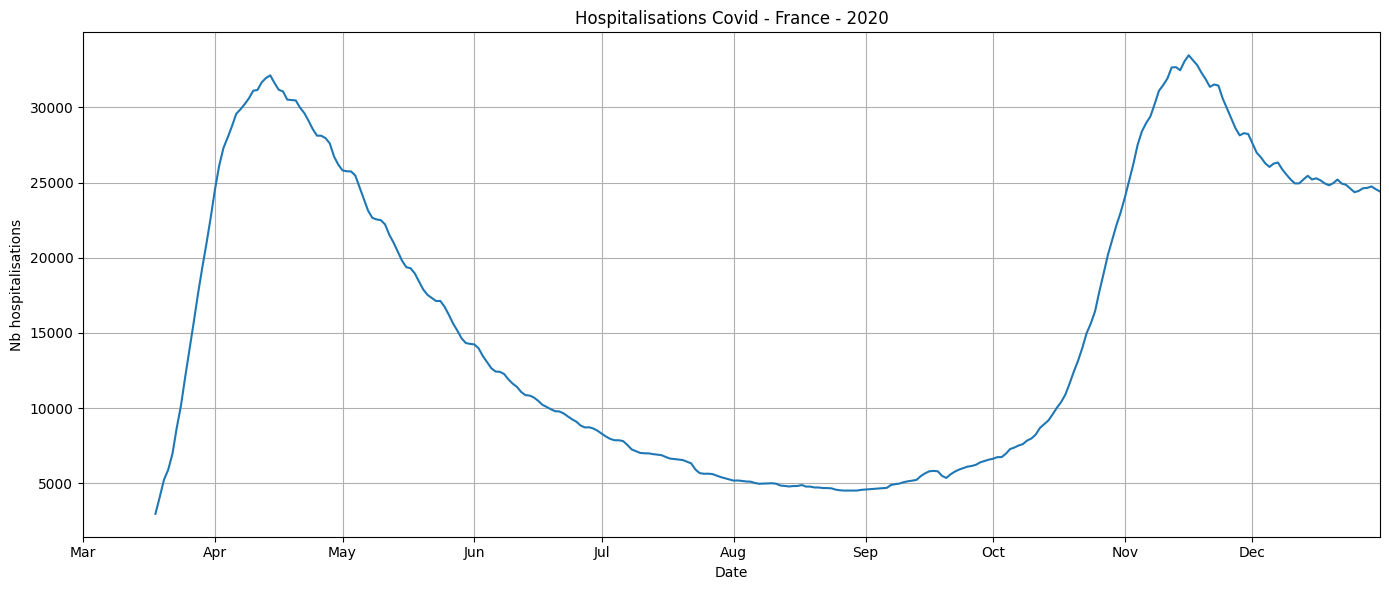

In [ ]:
df_daily['date'] = pd.to_datetime(df_daily['date'])   

plt.figure(figsize=(14,6))
plt.plot(df_daily['date'], df_daily['hosp'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-31'))   

plt.title("Hospitalisations Covid - France - 2020")
plt.xlabel("Date")
plt.ylabel("Nb hospitalisations")
plt.grid(True)
plt.tight_layout()
plt.show()


3. On représente le nombre d'absence au travail pour congé maladie en 2020

Problème: les données en open data ne sont disponibles qu'avec des divisions trimestrielles et non pas hebdomadaires

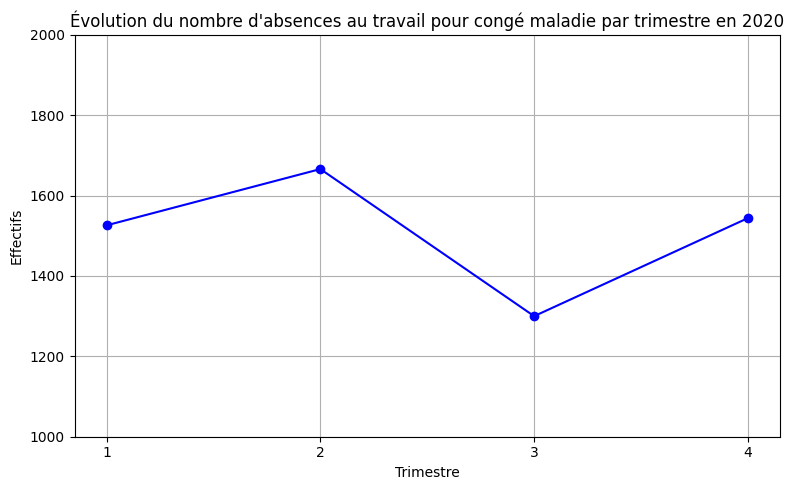

In [ ]:
# On ne compte que les absences au travail que pour des raisons de congé maladie
df_rabs2 = eec20[eec20['RABS'] == 2.0].copy()

# On les groupe par trimestre et on compte le nombre d'observations
df_trim_count = df_rabs2.groupby('TRIM', as_index=False).size().rename(columns={'size': 'Effectifs'})

# Représentation graphique:
plt.figure(figsize=(8,5))
plt.plot(df_trim_count['TRIM'], df_trim_count['Effectifs'], marker='o', linestyle='-', color='blue')
plt.title("Évolution du nombre d'absences au travail pour congé maladie par trimestre en 2020")
plt.xlabel("Trimestre")
plt.ylabel("Effectifs")
plt.ylim(1000, 2000) # revoir étiquettes car trompeuses ?
plt.xticks(df_trim_count['TRIM'])  # pour que chaque trimestre ait son label
plt.grid(True)
plt.tight_layout()
plt.show()

4. Représentons les données d'hospitalisation par trimestre pour mieux comparer

In [ ]:
df_daily['year'] = df_daily['date'].dt.year
df_daily['month'] = df_daily['date'].dt.month
df_daily_2020 = df_daily[df_daily['year'] == 2020].copy()

# 4) Calcul des trimestres
T1 = df_daily_2020[df_daily_2020['month'] == 3]['hosp'].sum() * 3 # T1 est corrigé (multiplié par 3) parce qu’il ne contient que mars
T2 = df_daily_2020[df_daily_2020['month'].isin([4,5,6])]['hosp'].sum()
T3 = df_daily_2020[df_daily_2020['month'].isin([7,8,9])]['hosp'].sum()
T4 = df_daily_2020[df_daily_2020['month'].isin([10,11,12])]['hosp'].sum()

df_trim = pd.DataFrame({
    "TRIM": ["T1","T2","T3","T4"],
    "hosp": [T1, T2, T3, T4]
})

           date  hosp
0    2020-03-18  2972
1    2020-03-19  4073
2    2020-03-20  5226
3    2020-03-21  5900
4    2020-03-22  6954
...         ...   ...
1195 2023-06-26  8856
1196 2023-06-27  8807
1197 2023-06-28  8721
1198 2023-06-29  8625
1199 2023-06-30  8540

[1200 rows x 2 columns]


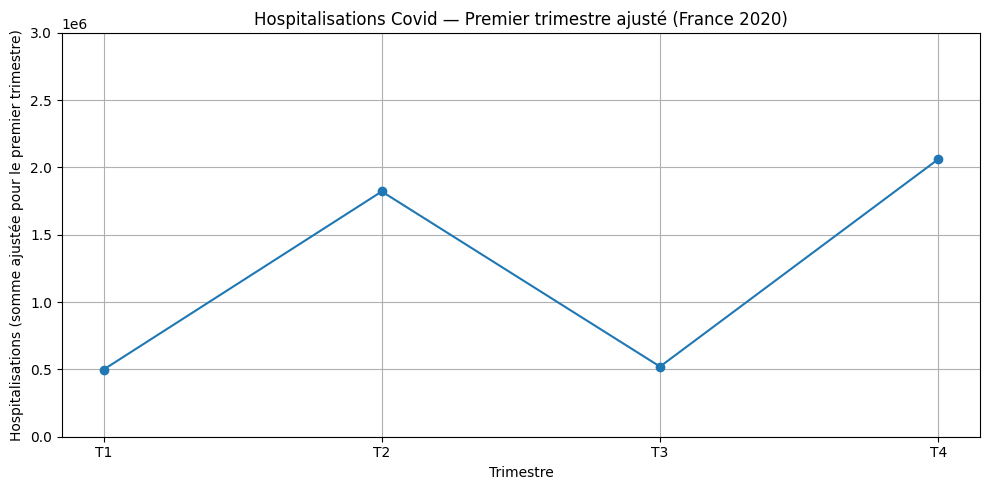

In [37]:
plt.figure(figsize=(10,5))
plt.plot(df_trim["TRIM"], df_trim["hosp"], marker="o")

plt.title("Hospitalisations Covid — Premier trimestre ajusté (France 2020)")
plt.xlabel("Trimestre")
plt.ylabel("Hospitalisations (somme ajustée pour le premier trimestre)")
plt.grid(True)
plt.ylim(0, 3000000)
plt.tight_layout()
plt.show()

=> jsp si c'est vraiment concluant d'agréger par trimestre en perdant plein d'information, il vaut peut être mieux récupérer d'autres données sur des arrêts de travail par jour / semaine 

+ attention ce sont pas les mêmes échelles: peut être trompeur
Mais globalement ce n'est pas le coeur du devoir, juste en intro et on voit bien le lien entre les deux variables: mtn but: différencier les secteurs d'activité


=> faire un score de corrélation ? 

In [34]:
df_trim.head()

,TRIM,hosp
0,T1,498366
1,T2,1821618
2,T3,520823
3,T4,2061422


In [33]:

df_trim_count.head()

,TRIM,Effectifs
0,1,1526
1,2,1666
2,3,1300
3,4,1544


In [ ]:
df_trim_count['TRIM'] = df_trim_count['TRIM'].map({1: 'T1', 2: 'T2', 3: 'T3', 4: 'T4'})

df_corr = pd.merge(df_trim, df_trim_count, on='TRIM', how='inner')

# Calcul de la corrélation
correlation = df_corr['hosp'].corr(df_corr['Effectifs'])

print("Corrélation trimestrielle hosp ↔ rabs=2 :", correlation)

Corrélation trimestrielle hosp ↔ rabs=2 : 0.6763742448418546

Table utilisée pour le calcul :

  TRIM     hosp  Effectifs
0   T1   498366       1526
1   T2  1821618       1666
2   T3   520823       1300
3   T4  2061422       1544
